# Statistiques Bayésienne : Méthodes de Monte-Carlo

In [88]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Les scripts de ce notebook ont été caché par souci de lecture, pour afficher le code, veuillez cliquer <a href="javascript:code_toggle()">ici</a>.''')

## 0 -  Importation des packages

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import numpy as np
from scipy.stats import norm
from scipy.stats import chi2
from scipy.stats import ks_2samp
from scipy.stats import uniform
from scipy.integrate import quad
from scipy.integrate import odeint

import warnings
warnings.filterwarnings('ignore')

## 1 - Générateur pseudo-aléatoire

La fonction **np.random.RandomState()** du package numpy instancie un conteneur pour la génération pseudo-alétoire de nombres à partir d'une graine spécifiable. La fonction utilise l'algorithme de **Mersenne Twister**. Cette fonction permet également de générer des tirages d'un certain nombre de lois usuelles par le calcul des quantiles de ces lois. Pour rappel, cette méthode génère des tirages pseudos-aléatoires de période $2^{19937}-1$ ce qui sera largement suffisant pour les tirages que nous réaliserons.

In [2]:
Randstate = np.random.RandomState()

#### Tirage de 1 000 000 échantillons de la loi $U([0,1])$ et visualisation par histogramme

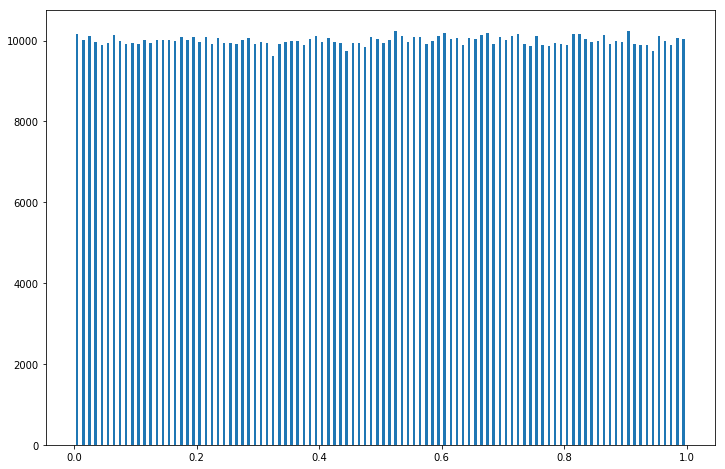

In [19]:
Uniform_sample = Randstate.uniform(0,1,1000000)
plt.figure(figsize=(12,8))
plt.hist(Uniform_sample , bins=100, rwidth=0.4)
plt.show()

#### Generation de 2 échantillons identiques

Cet algorithme est déterministe. Ainsi si cette fonction est instanciée avec la même graîne, elle generera les mêmes nombres. Ce que nous vérifions ci-dessous pour 10000 tirages.

In [44]:
Randstate_1 = np.random.RandomState(seed=43).uniform(0,1,10000)
Randstate_2 = np.random.RandomState(seed=43).uniform(0,1,10000)
print("Randstate_1 == Randstate_2")
Randstate_1 == Randstate_2

Randstate_1 == Randstate_2


array([ True,  True,  True, ...,  True,  True,  True])

## 2 - Acceptation rejet

Nous traçons la densité de probabilité f définie de la manière suivante: 

> $f(x) =  \frac{e^{-\frac{1}{2}(x-1)^{2}}|\sin(\pi x)|}{\int_{R}e^{-\frac{1}{2}(x-1)^{2}}|\sin(\pi x)|dx}$

Cette densité ressemble à l'expression de la densité d'une loi normale $N(1,1)$, aussi nous utiliserons comme densité q une loi normale $N(1,1)$. En vérifiant que cette densité domine uniformément la densité d'intérêt avec un facteur d'échelle M. 

> $\forall x \in R, 0 ≤ \frac{f(x)}{q(x)} =  \frac{e^{-\frac{1}{2}(x-1)^{2}}|\sin(\pi x)|\sqrt{2\pi}}{e^{-\frac{1}{2}(x-1)^{2}}\int_{R}e^{-\frac{1}{2}(x-1)^{2}}|\sin(\pi x)|dx}$

> $ 0 ≤ \frac{f(x)}{q(x)} ≤  \frac{\sqrt{2\pi}}{\int_{R}e^{-\frac{1}{2}(x-1)^{2}}|\sin(\pi x)|dx}$

> $f(x) ≤  \frac{\sqrt{2\pi}}{\int_{R}e^{-\frac{1}{2}(x-1)^{2}}|\sin(\pi x)|dx}q(x)$

Nous calculons alors la l'intégrale au dénominateur à l'aide de la fonction quad de scipy.integrate et traçons les 2 densités. L'intérêt d'avoir une majoration précise est d'optimiser la procédure d'acceptation rejet par la suite.

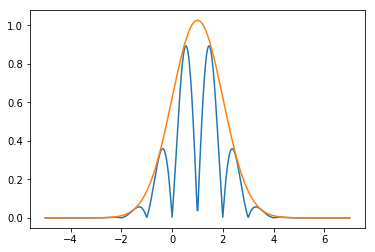

In [74]:
density = lambda x: np.exp(-0.5*(x-1)**2)*np.abs(np.sin(np.pi*x))
M = np.sqrt(2*np.pi) / quad(density, - np.inf, + np.inf)[0]

plt.figure()
plt.plot(np.linspace(-5,7,500),[density(u) for u in np.linspace(-5,7,500)])
plt.plot(np.linspace(-5,7,500),[norm.pdf(u,1,1)*(M+1) for u in np.linspace(-5,7,500)])

#### fonction de génération par acceptation rejet pour une longueur n et une graine s spécifiées

In [37]:
def acceptation_rejet(density = density, n=1000, seed=43):
    rs = np.random.RandomState(seed)
    vec = []
    while len(vec)<n:
        y = rs.normal(1,1)
        if rs.uniform(0,1) <= density(y)/((M+1)*norm.pdf(y,1,1)):
            vec.append(y)
    return vec        

#### Essai sur 100 000 points et visualisation de l'histogramme du tirage

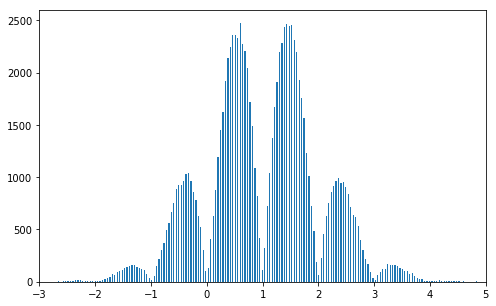

In [38]:
vec = acceptation_rejet(density, 100000, 43)

plt.figure(figsize=(8,5))
plt.hist(vec, bins=200,rwidth=0.5)
plt.xlim([-3,5])
plt.show()

## 3 - Algorithme de Métropolis-Hastings

Nous proposons ici une implémentation de l'algorithme de métroplis Hastings pour la génération d'une loi du $\chi^{2}$ à 3 degrés de libertés. 

La densité insrumentale suggérée est $q(y|x) = \frac{1}{s}\varphi(\frac{x-y}{s})$ ou $\varphi$ est la densité d'une loi Normale N(0,1).

Par conséquent le rapport d'acceptation $\rho = \frac{p(y)q(x|y)}{p(x)q(y|x)}$ se simplifie par symétrie de la densité instrumentale q.

NB: Par souci de stabilité, nous utilisons la logprobabilité dans le calcul du rapport d'acceptation.

#### Défintion des fonctions utilisées

In [49]:
logpdf = lambda x: np.log(chi2.pdf(x,3))
logproppdf = lambda y,x,s: np.log(norm.pdf(y, x, s))

#### Défintion de mhsim

In [50]:
def mhsim(logpdf=logpdf, logproppdf=logproppdf, x0=0, nsamples=50000, s = 1e-3, seed=43):
    rs = np.random.RandomState(seed)
    vec = []
    count = 0 
    if x0 ==0:
        x_i = 1e-12 #évite la division intitiale par zéro
    else:
        x_i = x0
    while len(vec)<nsamples:
        count +=1
        if count%10000 == 0: # Introduction d'un compteur pour vérifier que la fonction tourne
            print(count)
        y = rs.normal(x_i,s)
        rho = np.exp(logpdf(y)-logpdf(x_i)) # la densité instrumentale est symétrique donc le rapport se simplifie
        if rho >=1:
            vec.append(y)
            x_i = y
        else:
            if rs.binomial(1,rho):
                vec.append(y)
                x_i = y
            else:
                pass
    return vec, nsamples/count

In [51]:

vec_1, acceptation_ratio_1 = mhsim(logpdf=logpdf, logproppdf=logproppdf, x0=0, nsamples=50000, s = 10, seed=43)
vec_2, acceptation_ratio_2 = mhsim(logpdf=logpdf, logproppdf=logproppdf, x0=0, nsamples=50000, s = 1, seed=43)
vec_3, acceptation_ratio_3 = mhsim(logpdf=logpdf, logproppdf=logproppdf, x0=0, nsamples=50000, s = 1e-1, seed=43)
vec_4, acceptation_ratio_4 = mhsim(logpdf=logpdf, logproppdf=logproppdf, x0=0, nsamples=50000, s = 1e-2, seed=43)


//anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
10000
20000
30000
40000
50000
60000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000


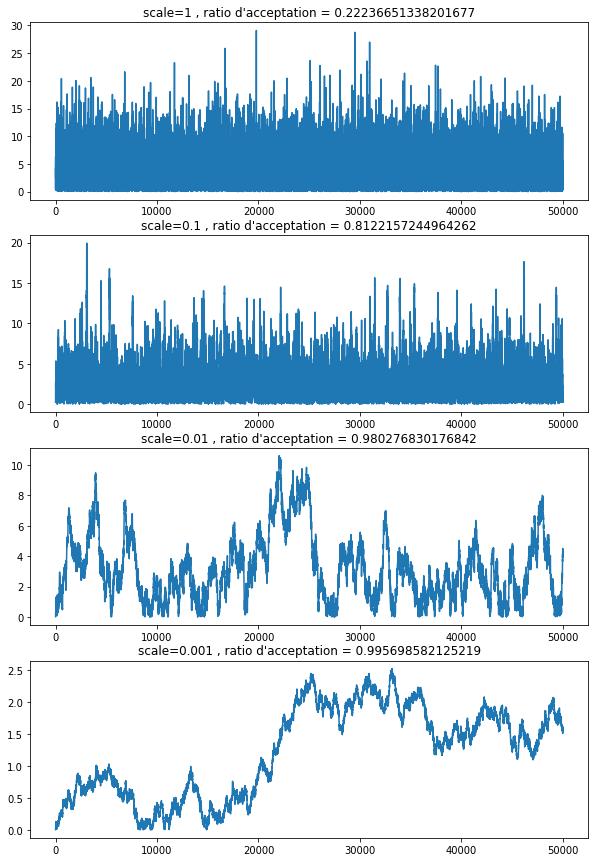

In [52]:
fig, a = plt.subplots(4,1, figsize=(10,15))
a[0].plot(vec_1)
a[0].set_title("scale=1 , ratio d'acceptation = {}".format(acceptation_ratio_1))
a[1].plot(vec_2)
a[1].set_title("scale=0.1 , ratio d'acceptation = {}".format(acceptation_ratio_2))
a[2].plot(vec_3)
a[2].set_title("scale=0.01 , ratio d'acceptation = {}".format(acceptation_ratio_3))
a[3].plot(vec_4)
a[3].set_title("scale=0.001 , ratio d'acceptation = {}".format(acceptation_ratio_4))
plt.show()

In [53]:
print(acceptation_ratio_1,'\n',acceptation_ratio_2,'\n',acceptation_ratio_3,'\n',acceptation_ratio_4)

0.22236651338201677 
 0.8122157244964262 
 0.980276830176842 
 0.995698582125219


**Interpretation** On voit que **l'échelle utilisée pour la densité instrumentale influe sur l'exploration du support de notre fonction d'intérêt**. Ainsi, une échelle trop petite entrainera un mauvais "mélange" de notre chaîne de Markov car les pas d'exploration seront trop petits (Ratio d'acceptation proches de 1 pour les S petits et pas de comportement de convergence de la chaîne tracée)

### Réglage automatique du taux d'acceptation

Nous proposons de créer une fonction qui demande à l'utilisateur de spécifier un ratio d'acceptation donné. Par la suite, l'algorithme surveille le taux d'acceptation "courant" (i.e sur les n derniers tirages, ou n est un paramètre spécifiable) et adapte la variance de la densité instrumentale en fonction de ce ratio. 

> Si le ratio est trop grand, nous **augmentons la variance** de la densité instrumentale d'un facteur linéairement dépendant de l'écart entre le ratio demandé et le ratio courant pour explorer plus largement l'espace. 

> Si le ratio est trop petit, nous **diminuons la variance** de la densité instrumentale d'un facteur linéairement dépendant de l'écart entre le ratio demandé et le ratio courant pour augmenter le nombre de tirage dans le support de la densité d'intéret. 

> Nous définissons une fenêtre de +- 1% pour le ratio d'acceptation mais cela peut être un paramètre spécifiable pour l'algorithme.

In [55]:
def mhsim_auto_scale(logpdf, logproppdf, x0=0, nsamples=50000, s = 1e-3, ratio=0.95, seed=43):
    rs = np.random.RandomState(seed)
    vec = []
    count = 0 
    count_scale = 0
    if x0 ==0:
        x_i = 1e-12
    else:
        x_i = x0
    while len(vec)<nsamples:
        count +=1
        
        # controle du ratio d'acceptation sur les 1000 derniers tirages
        if count%1000 == 0:
            current_ratio = count_scale/1000
            if current_ratio < (ratio - 0.01):
                s=s*(1-(ratio-current_ratio))
            elif current_ratio > (ratio - 0.01):
                s=s*(1-(ratio-current_ratio))
            count_scale = 0
        
        #Tirage aléatoire et acceptation-rejet
        y = rs.normal(x_i,s)
        rho = np.exp(logpdf(y)-logpdf(x_i)) # la densité instrumentale est symétrique 
        if rho >=1:
            count_scale +=1
            vec.append(y)
            x_i = y
        else:
            if rs.binomial(1,rho):
                vec.append(y)
                x_i = y
                count_scale +=1
            else:
                pass
    return vec, nsamples/count

vec_5, acceptation_ratio_5 = mhsim_auto_scale(logpdf=logpdf, logproppdf=logproppdf, x0=0, nsamples=50000, s = 1e-1, ratio=0.60, seed=43)
     

//anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


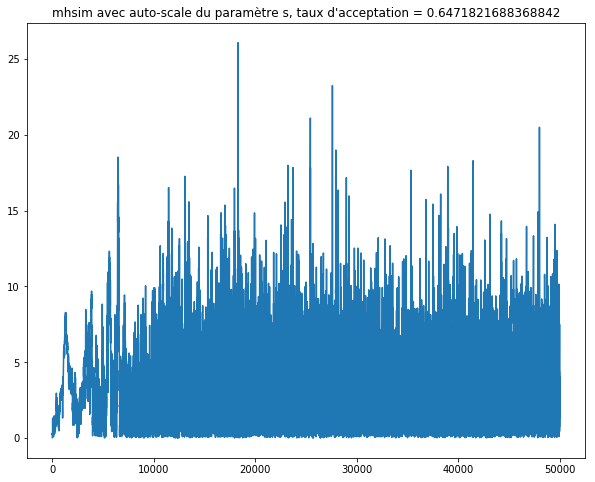

In [56]:
fig, a = plt.subplots(1,1, figsize=(10,8))
a.plot(vec_5)
a.set_title("mhsim avec auto-scale du paramètre s, taux d'acceptation = {}".format(acceptation_ratio_5))
fig.show()

#### Diagnostic automatique d'un problème de convergence à partir de plusieurs simulations

Nous proposons içi de générer plusieurs chaînes issues d'état initiaux différents (nb de répétitions et génération des états initiaux spécifiable par l'utilisateur) et de vérifier qu'elles convergent bien vers une distribution unique par des tests croisés de Kolmogorov Smirnov qui sont des tests non-paramétriques comparant la statistique du maximum de l'écart des fonctions de répartition empirique à la loi $U([0,1])$.

Pour rappel la statistique de ce test pour la comparaison de 2 échantillons de taille n est:

> $D_{KS}(X,Y)= \|F_{n}(X) - F_{n}(Y)\|_{\infty}$ ou $F_{n}$ est la fonction de répartition empirique



#### Génération des chaînes

In [133]:
def mhsim_auto_scale_convergence(logpdf, logproppdf, x0=0, nsamples=30000, s = 1e-3, ratio=0.95, n_iter=5):
    vec = [[] for i in range(n_iter)]
    acceptation_ratios = []
    tests=[[] for i in range(n_iter)]
    for i in range(n_iter):
        print("{}ème itération".format(i))
        rs = np.random.RandomState(np.random.randint(100))
        count = 0
        scale = s
        count_scale = 0
        x_i = rs.uniform(0,10)
        while len(vec[i])<nsamples:
            count +=1
            # Acceptation ratio update sur les 1000 derniers tirages
            if count%1000 == 0:
                current_ratio = count_scale/1000
                if current_ratio < (ratio - 0.02):
                    scale=scale*(1-(ratio-current_ratio))
                elif current_ratio > (ratio - 0.02):
                    scale=scale*(1-(ratio-current_ratio))
                count_scale = 0
            #Tirage aléatoire et acceptation-rejet
            y = rs.normal(x_i,scale)
            rho = np.exp(logpdf(y)-logpdf(x_i)) # la densité instrumentale est symétrique 
            if rho >=1:
                count_scale +=1
                vec[i].append(y)
                x_i = y
            else:
                if rs.binomial(1,rho):
                    vec[i].append(y)
                    x_i = y
                    count_scale +=1
                else:
                    pass
        acceptation_ratios.append(nsamples/count)
        for j in range(i):
            tests[i].append(ks_2samp(vec[i][20000:],vec[j][20000:]))
    return vec, acceptation_ratios, tests

vecs, acceptation_ratios, tests = mhsim_auto_scale_convergence(logpdf=logpdf, logproppdf=logproppdf, x0=0, nsamples=50000, s = 1e-3, ratio=0.40, n_iter=5)
         
      

0ème itération


//anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


1ème itération
2ème itération
3ème itération
4ème itération


(0, 15)

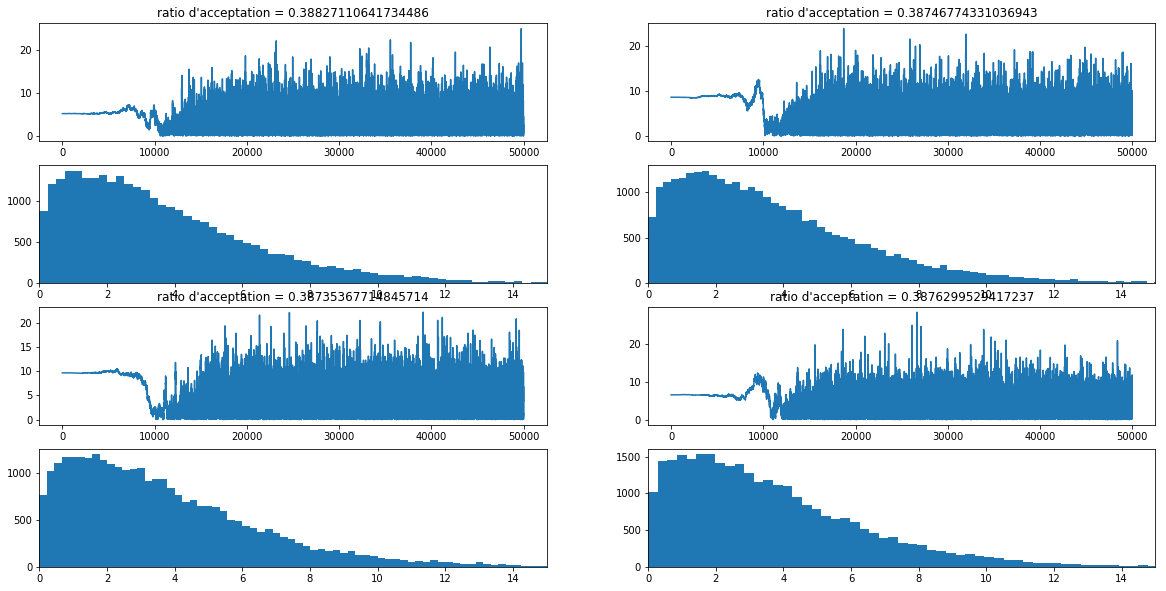

In [134]:
fig, a = plt.subplots(4,2, figsize=(20,10))
for i in range(2):
    a[i//2,i%2].plot(vecs[i])
    a[i//2,i%2].set_title("ratio d'acceptation = {}".format(acceptation_ratios[i]))
    a[i//2+1,i%2].hist(vecs[i][20000:], bins=100)
    a[i//2+1,i%2].set_xlim([0,15])

a[2,0].plot(vecs[2])
a[2,0].set_title("ratio d'acceptation = {}".format(acceptation_ratios[2]))
a[3,0].hist(vecs[2][20000:], bins=100)
a[3,0].set_xlim([0,15])

a[2,1].plot(vecs[3])
a[2,1].set_title("ratio d'acceptation = {}".format(acceptation_ratios[3]))
a[3,1].hist(vecs[3][20000:], bins=100)
a[3,1].set_xlim([0,15])


In [135]:
tests

[[],
 [Ks_2sampResult(statistic=0.009933333333333322, pvalue=0.10300582027466032)],
 [Ks_2sampResult(statistic=0.00993333333333335, pvalue=0.10300582027465868),
  Ks_2sampResult(statistic=0.007900000000000018, pvalue=0.30530225211885786)],
 [Ks_2sampResult(statistic=0.006333333333333413, pvalue=0.5829094090967646),
  Ks_2sampResult(statistic=0.0092666666666667, pvalue=0.15129734765076944),
  Ks_2sampResult(statistic=0.013066666666666671, pvalue=0.011806515195203498)],
 [Ks_2sampResult(statistic=0.008666666666666656, pvalue=0.20892467376087226),
  Ks_2sampResult(statistic=0.007633333333333381, pvalue=0.34521910769646125),
  Ks_2sampResult(statistic=0.012266666666666648, pvalue=0.0217117020948738),
  Ks_2sampResult(statistic=0.007333333333333331, pvalue=0.3940674957429291)]]

**Interprétation** Malgré des initialisations différentes, les chaînes semblent converger vers une distribution identique pour chacune des experiences. Nous avons volontairement choisi un ratio d'acceptation bas (0.40), la méthode proposée semble donner des ratios proches de la valeur spécifiée. Nous affichons les histogrammes et étudions les tests statistiques associés à ces distributions tronquées pour les 20 000 premières observations (phase de brûlage).

Les résultats des tests statistiques semblent montrer que l'on peut statistiquement considérer que les tirages sont générés à partir de la même loi de distribution. La forme des histogrammes évoque une loi du $\chi^{2}$ à 3 degrés de liberté qui est effectivement la loi postérieure utilisée dans ce problème. Ce que confirme le test KS suivant avec une simulation du $\chi^{2}(3)$.

In [7]:
ks_2samp(vec[0][20000:],np.random.chisquare(3, 20000))

Ks_2sampResult(statistic=0.005049999999999999, pvalue=0.9602420972994593)

## 4 - Un problème d'estimation 

Le problème est un système différentiel du premier degré qui peut être résolu analytiquement ou par calcul numérique. Nous utiliserons dans cette partie, la fonction **odeint** de scipy qui permet la résolution de systèmes d'équations différentielles ordinaires. 

### 4.1 Construction du simulateur et du vecteur d'observations bruité

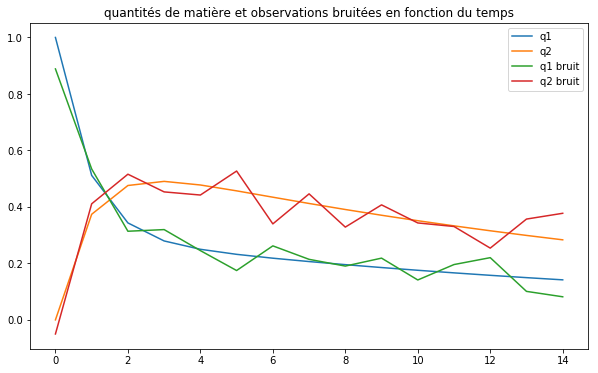

In [17]:
def simulateur(x, q0, t):
    
    def f(q, t, x):
        q_= [-(x[0]+x[2])*q[0] + x[1]*q[1], x[0]*q[0] - x[1]*q[1]]
        return q_
    
    time = np.linspace(0, t, t)
    
    return odeint(f, q0, time, args=(x,))

q0 = np.array([1,0])
x = np.array([0.6,0.35,0.15])
simu = simulateur(x, q0, 15)

rs = np.random.RandomState()
obs = rs.normal(simu, 0.05 )

plt.figure(figsize=(10,6))
plt.plot(simu[:,0], label='q1')
plt.plot(simu[:,1], label='q2')
plt.plot(obs[:,0], label='q1 bruit')
plt.plot(obs[:,1], label='q2 bruit')
plt.title('quantités de matière et observations bruitées en fonction du temps')
plt.legend()

### 4.2 Représentation graphique de la loi à posteriori de  X

Nous représentons içi la densité de la loi à posteriori $p(\theta|y) = \frac{p(y|\theta)\pi(\theta)}{p(y)}$ en fonction de paramètres fixés pour $\theta$

>  la loi conditionelle $p(y|\theta) \sim N(q(\theta),t),s^{2}), \forall y \in R^{15} p(y|\theta)=$ 
$\frac{1}{(2\pi)^{15/2}s^{15}}\prod\limits_{i=1}^{15} e^{-\frac{(y-q(x,t_{i})^{2}}{2s}}$

> la loi a priori $\pi(\theta) \sim U([0,1]^{3}), \forall \theta \in [0,1]^{3}, \pi(\theta) = 1$ puisque la loi est uniforme, elle peut être ignorée dans le calcul de la loi à posteriori.

> l'evidence p(y) que nous n'avons pas besoin de calculer puisque nous représentons la loi à une constante multiplicative près


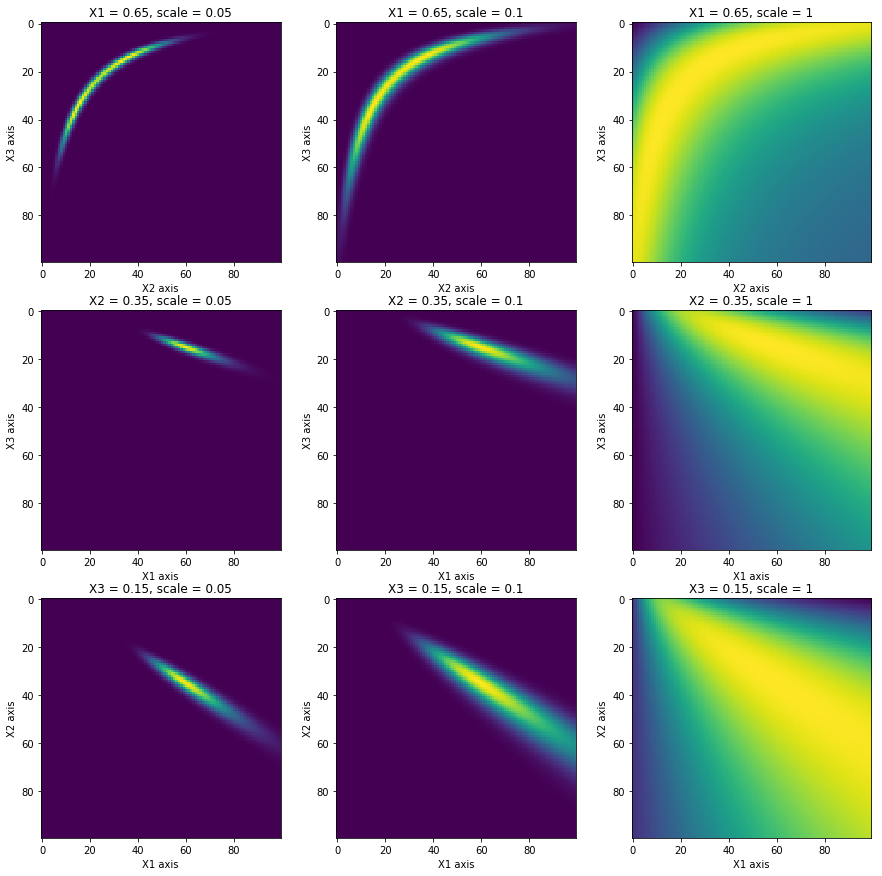

In [158]:
###Computing posterior probability #####
P_theta = lambda y, sigma2: np.prod(norm.pdf(y, simu[:,1], sigma2))
#Prior = lambda theta: np.prod([uniform.pdf(theta[i], loc=0, scale=1) for i in range(3)])
Posterior = lambda y, sigma2, theta: P_theta(y, sigma2)#*Prior(theta)

Post_0_6 = []
Post_0_35 = []
Post_0_15 = []

for s in [0.05, 0.1, 1]:
    space = np.linspace(0,1,100)
    space_1,space_2 = np.meshgrid(space ,space)
    space = np.array([space_1.flatten(),space_2.flatten()]).T

    space_0_6 = np.vstack((np.ones(10000)*0.6,space.T)).T
    Post_0_6.append(np.array([Posterior(simulateur(i, q0, 15)[:,1], s, i) for i in space_0_6]).reshape(space_1.shape))

    space_0_35 = np.vstack((space.T[0], np.ones(10000)*0.35, space.T[1])).T
    Post_0_35.append(np.array([Posterior(simulateur(i, q0, 15)[:,1], s, i) for i in space_0_35]).reshape(space_1.shape))

    space_0_15 = np.vstack((space.T, np.ones(10000)*0.15)).T
    Post_0_15.append(np.array([Posterior(simulateur(i, q0, 15)[:,1], s, i) for i in space_0_15]).reshape(space_1.shape))
    
fig ,a = plt.subplots(3,3,figsize=(15,15))
for i,s in enumerate([0.05, 0.1, 1]):
    a[0,i].imshow(Post_0_6[i],cmap=cm.viridis)
    a[0,i].set_xlabel('X2 axis')
    a[0,i].set_ylabel('X3 axis')
    a[0,i].set_title('X1 = 0.65, scale = {}'.format(s))
    a[1,i].imshow(Post_0_35[i],cmap=cm.viridis)
    a[1,i].set_xlabel('X1 axis')
    a[1,i].set_ylabel('X3 axis')
    a[1,i].set_title('X2 = 0.35, scale = {}'.format(s))
    a[2,i].imshow(Post_0_15[i],cmap=cm.viridis)
    a[2,i].set_xlabel('X1 axis')
    a[2,i].set_ylabel('X2 axis')
    a[2,i].set_title('X3 = 0.15, scale = {}'.format(s))

**Interprétation**. La concentration des valeurs hautes de la vraissemblance de la loi postérieure diminue à mesure que le bruit d'observation augmente. Dans la suite, nous fixons l'écart-type de la loi normal du bruit à s = 0.05

#### Représentation 3D  pour s=0.1

In [ ]:
fig = plt.figure(figsize=(10,15))
a = fig.add_subplot(3, 1, 1, projection='3d')
a.plot_surface(space_1,space_2,Post_0_6,cmap=cm.viridis)
a.set_xlabel('X2 axis')
a.set_ylabel('X3 axis')
a.set_title('X1 = 0.65 ')
a = fig.add_subplot(3, 1, 2, projection='3d')
a.plot_surface(space_1,space_2,Post_0_35,cmap=cm.viridis)
a.set_xlabel('X1 axis')
a.set_ylabel('X3 axis')
a.set_title('X2 = 0.35 ')
a = fig.add_subplot(3, 1, 3, projection='3d')
a.plot_surface(space_1,space_2,Post_0_15,cmap=cm.viridis)
a.set_xlabel('X1 axis')
a.set_ylabel('X2 axis')
a.set_title('X3 = 0.15 ')
plt.show()

### 4.3 Metropolis-Hastings 

Nous pouvons proposer 2 versions de l'algorithme. L'une est la **généralisation de la méthode d'acceptation-rejet** présentée plus haut et où **les tirages sont indépendants** les uns des autres. Dans ce cas, la distribution de probabilité à priori utilisée est la loi uniforme sur l'hypercube [0,1], la densité est donce neutre du point de vue du ratio d'acceptation. L'autre se base sur **la construction d'une chaîne de Markov grâce au noyau de transition gaussien**. 

#### 4.3.1 Metropolis Hastings indépendant

In [35]:
def MH_simu(x0=0, ratio=0.30, nsamples=10000, s = 0.005, n_iter=1, noise=0.05, q0 = np.array([1,0])):
    
    Posterior = lambda y: np.prod(norm.pdf(y, simu[:,1], noise))
    
    vec = [[] for i in range(n_iter)]
    acceptation_ratios = []
    tests=[[] for i in range(n_iter)]
    scale=s
    
    for i in range(n_iter):
        
        print("{}ème itération".format(i))
        rs = np.random.RandomState(np.random.randint(100))
        count = 0
        count_scale = 0
        theta = rs.uniform(0,1,3) #initialisation avec une uniforme
        x_i = simulateur(theta, q0, 15)[:,1]
        
        while len(vec[i])<nsamples:
            
            count +=1
            # Acceptation ratio sur les 1000 derniers tirages
            if count%1000 == 0:
                current_ratio = count_scale/1000
                #if current_ratio < (ratio - 0.02) or current_ratio > (ratio - 0.02):
                #    scale=scale*(1-(ratio-current_ratio)/10)
                count_scale = 0
                print(current_ratio, len(vec[i]), scale)
                
            #Tirage aléatoire et acceptation-rejet
            #theta_ = rs.normal(theta,scale)
            theta_ = rs.uniform(0,1,3)
            
            y = simulateur(theta_, q0, 15)[:,1] #simulation
            
            rho = Posterior(y)/Posterior(x_i)# la densité instrumentale est symétrique 
            if rho >=1:
                theta = theta_
                vec[i].append(theta)
                x_i = y
                count_scale +=1
            else:
                if rs.binomial(1,rho):
                    theta = theta_
                    vec[i].append(theta)
                    x_i = y
                    count_scale +=1
                else:
                    pass
        acceptation_ratios.append(nsamples/count)
    return vec, acceptation_ratios, tests

vec_simu, acceptation_ratios_simu, tests_simu = MH_simu()
vec_simu = np.array(vec_simu[0])
print("ratio d'acceptation", acceptation_ratios_simu)

0ème itération
0.017 17 0.005
0.015 32 0.005
0.011 43 0.005
0.008 51 0.005
0.019 70 0.005
0.013 83 0.005
0.015 98 0.005
0.015 113 0.005
0.014 127 0.005
0.02 147 0.005
0.018 165 0.005
0.022 187 0.005
0.016 203 0.005
0.007 210 0.005
0.019 229 0.005
0.02 249 0.005
0.013 262 0.005
0.02 282 0.005
0.01 292 0.005
0.009 301 0.005
0.007 308 0.005
0.01 318 0.005
0.011 329 0.005
0.024 353 0.005
0.01 363 0.005
0.011 374 0.005
0.018 392 0.005
0.014 406 0.005
0.019 425 0.005
0.012 437 0.005
0.015 452 0.005
0.003 455 0.005
0.011 466 0.005
0.017 483 0.005
0.011 494 0.005
0.014 508 0.005
0.023 531 0.005
0.019 550 0.005
0.017 567 0.005
0.019 586 0.005
0.03 616 0.005
0.014 630 0.005
0.018 648 0.005
0.029 677 0.005
0.009 686 0.005
0.014 700 0.005
0.022 722 0.005
0.015 737 0.005
0.018 755 0.005
0.012 767 0.005
0.021 788 0.005
0.022 810 0.005
0.016 826 0.005
0.013 839 0.005
0.025 864 0.005
0.015 879 0.005
0.014 893 0.005
0.016 909 0.005
0.013 922 0.005
0.011 933 0.005
0.013 946 0.005
0.007 953 0.005
0.012 9

0.018 7386 0.005
0.007 7393 0.005
0.018 7411 0.005
0.008 7419 0.005
0.003 7422 0.005
0.021 7443 0.005
0.01 7453 0.005
0.006 7459 0.005
0.017 7476 0.005
0.025 7501 0.005
0.019 7520 0.005
0.01 7530 0.005
0.01 7540 0.005
0.014 7554 0.005
0.019 7573 0.005
0.01 7583 0.005
0.022 7605 0.005
0.023 7628 0.005
0.025 7653 0.005
0.008 7661 0.005
0.022 7683 0.005
0.014 7697 0.005
0.011 7708 0.005
0.012 7720 0.005
0.015 7735 0.005
0.021 7756 0.005
0.023 7779 0.005
0.023 7802 0.005
0.02 7822 0.005
0.02 7842 0.005
0.017 7859 0.005
0.012 7871 0.005
0.021 7892 0.005
0.018 7910 0.005
0.012 7922 0.005
0.015 7937 0.005
0.016 7953 0.005
0.016 7969 0.005
0.012 7981 0.005
0.008 7989 0.005
0.018 8007 0.005
0.017 8024 0.005
0.02 8044 0.005
0.018 8062 0.005
0.014 8076 0.005
0.016 8092 0.005
0.013 8105 0.005
0.015 8120 0.005
0.019 8139 0.005
0.011 8150 0.005
0.03 8180 0.005
0.018 8198 0.005
0.015 8213 0.005
0.024 8237 0.005
0.013 8250 0.005
0.014 8264 0.005
0.02 8284 0.005
0.019 8303 0.005
0.019 8322 0.005
0.017 

Text(0.5, 1.0, 'X3 hist')

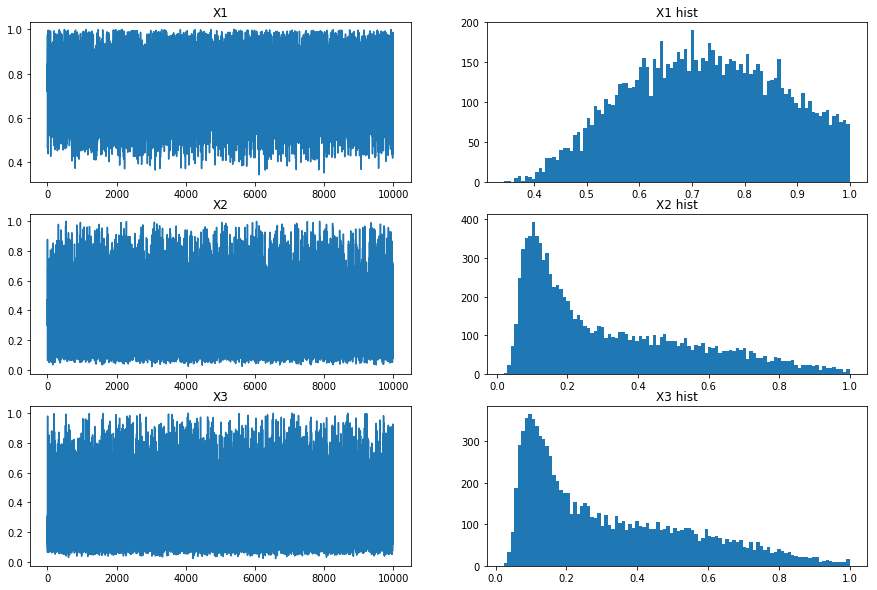

In [36]:
fig, a = plt.subplots(3,2, figsize=(15,10))
a[0,0].plot(vec_simu[:,0])
a[0,0].set_title('X1')
a[1,0].plot(vec_simu[:,1])
a[1,0].set_title('X2')
a[2,0].plot(vec_simu[:,2])
a[2,0].set_title('X3')
a[0,1].hist(vec_simu[:,0], bins=100)
a[0,1].set_title('X1 hist')
a[1,1].hist(vec_simu[:,1], bins=100)
a[1,1].set_title('X2 hist')
a[2,1].hist(vec_simu[:,2], bins=100)
a[2,1].set_title('X3 hist')

#### Estimation du maximum de la quantité de matière dans le compartiment

Notre chaîne nous ayant fourni des échantillons du paramètre x (ou $\theta$) distribués selon la loi à posteriori $p(\theta|y)$, nous pouvons calculer l'estimateur bayesien $\skew{1}\hat\theta_{BAYES} = \int_{\Theta}\theta p(\theta|y)d\theta$ de ce paramètre que nous estimerons par l'estimateur empirique $(\frac{\sum_{i\in I}\theta_{k,i}}{|I|})_{k \in {(1,2,3)}}$ (LFGN et théorème de Slutsky), et ainsi l'utiliser dans le simulateur du système physique pour obtenir le maximum de la quantité de matière dans le second compartiment. 

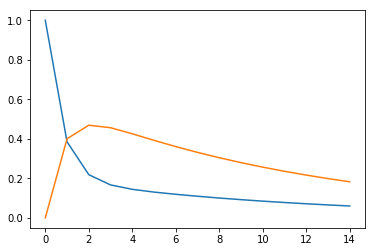

Estimation du vecteur x = [0.7243225  0.3186821  0.31979146]
Estimation empirique du maximum a posteriori de la quantité de matière dans le compartiment 2 = 0.46901813689238175


In [37]:
estim = np.mean(vec_simu, axis=0)
simu_ = simulateur(estim, q0, 15)
plt.plot(simu_)
plt.show()
print('Estimation du vecteur x =', estim)
print('Estimation empirique du maximum a posteriori de la quantité de matière dans le compartiment 2 =',np.max(simu_[:,1]))


### Metroplis-Hastings par noyau de transition gaussien

NB: Nous voyons que la chaine mélange mal, cela est du au fait que nous ne pouvons trop augmenter la variance sans rsiquer de dériver hors de l'hypercube [0,1]. Une solution consiste à "forcer" la chaîne à rester dans $[0,1]^{3}$

In [46]:
def MH_simu(x0=0, ratio=0.30, nsamples=10000, s = 0.005, n_iter=1, noise=0.05, q0 = np.array([1,0])):
    
    Posterior = lambda y: np.prod(norm.pdf(y, simu[:,1], noise))
    #Prior = lambda y, mean, sigma2: np.prod(norm.pdf(y, mean, sigma2))
    
    vec = [[] for i in range(n_iter)]
    acceptation_ratios = []
    tests=[[] for i in range(n_iter)]
    scale=s
    
    for i in range(n_iter):
        
        print("{}ème itération".format(i))
        rs = np.random.RandomState(np.random.randint(100))
        count = 0
        count_scale = 0
        theta = rs.uniform(0,1,3) #initialisation avec une uniforme
        x_i = simulateur(theta, q0, 15)[:,1]
        
        while len(vec[i])<nsamples:
            
            count +=1
            # Acceptation ratio sur les 1000 derniers tirages
            if count%1000 == 0:
                current_ratio = count_scale/1000
                if current_ratio < (ratio - 0.02) or current_ratio > (ratio - 0.02):
                    scale=scale*(1-(ratio-current_ratio)/10)
                count_scale = 0
                print(current_ratio, len(vec[i]), scale)
                
            #Tirage aléatoire et acceptation-rejet
            theta_ = rs.normal(theta,scale)
            #theta_ = rs.uniform(0,1,3)
            
            y = simulateur(theta_, q0, 15)[:,1] #simulation
            
            rho = Posterior(y)/Posterior(x_i)# la densité instrumentale est symétrique 
            if rho >=1:
                theta = theta_
                vec[i].append(theta)
                x_i = y
                count_scale +=1
            else:
                if rs.binomial(1,rho):
                    theta = theta_
                    vec[i].append(theta)
                    x_i = y
                    count_scale +=1
                else:
                    pass
        acceptation_ratios.append(nsamples/count)
    return vec, acceptation_ratios, tests

vec_simu, acceptation_ratios_simu, tests_simu = MH_simu()
vec_simu = np.array(vec_simu[0])
print("ratio d'acceptation", acceptation_ratios_simu)

0ème itération
0.834 834 0.005267
0.859 1693 0.005561425300000001
0.829 2522 0.00585562469837
0.823 3345 0.0061618738700947515
0.82 4165 0.006482291311339679
0.827 4992 0.00682390806344728
0.768 5760 0.007143266960816612
0.796 6556 0.007497573002073116
0.764 7320 0.00784546038936931
0.791 8111 0.008230672494487341
0.726 8837 0.008581299142752501
0.744 9581 0.008962308824690712
ratio d'acceptation [0.7957981855801369]


Text(0.5, 1.0, 'X3 hist')

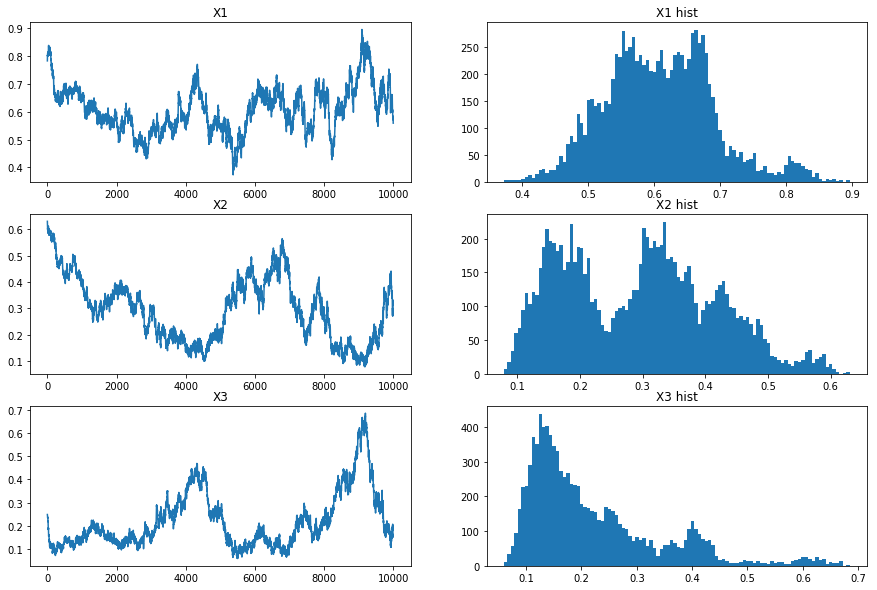

In [47]:
fig, a = plt.subplots(3,2, figsize=(15,10))
a[0,0].plot(vec_simu[:,0])
a[0,0].set_title('X1')
a[1,0].plot(vec_simu[:,1])
a[1,0].set_title('X2')
a[2,0].plot(vec_simu[:,2])
a[2,0].set_title('X3')
a[0,1].hist(vec_simu[:,0], bins=100)
a[0,1].set_title('X1 hist')
a[1,1].hist(vec_simu[:,1], bins=100)
a[1,1].set_title('X2 hist')
a[2,1].hist(vec_simu[:,2], bins=100)
a[2,1].set_title('X3 hist')

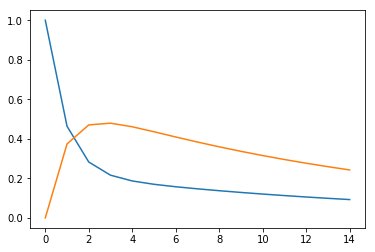

Estimation du vecteur x = [0.60803816 0.29373469 0.22114236]
Estimation empirique du maximum a posteriori de la quantité de matière dans le compartiment 2 = 0.47918809761490994


In [48]:
estim = np.mean(vec_simu, axis=0)
simu_ = simulateur(estim, q0, 15)
plt.plot(simu_)
plt.show()
print('Estimation du vecteur x =', estim)
print('Estimation empirique du maximum a posteriori de la quantité de matière dans le compartiment 2 =',np.max(simu_[:,1]))

**Interprétation** Nous voyons que la chaîne mélange très mal car la variance est trop faible. Toutefois, l'augmentation de la variance fait diverger la chaîne hors de l'hypercube. Ce que nous corrigeons dans l'algorithme suivant en forçant la chaîne à tester dans l'hypercube $[0,1]^{3}$

#### Un autre tirage de MH

In [84]:
def MH_simu(x0=0, ratio=0.30, nsamples=10000, s = 0.1, n_iter=1, noise=0.05, q0 = np.array([1,0])):
    
    Posterior = lambda y: np.prod(norm.pdf(y, simu[:,1], noise))
    #Prior = lambda y, mean, sigma2: np.prod(norm.pdf(y, mean, sigma2))
    
    vec = [[] for i in range(n_iter)]
    acceptation_ratios = []
    tests=[[] for i in range(n_iter)]
    scale=s
    
    for i in range(n_iter):
        
        print("{}ème itération".format(i))
        rs = np.random.RandomState(np.random.randint(100))
        count = 0
        count_scale = 0
        theta = rs.uniform(0,1,3) #initialisation avec une uniforme
        x_i = simulateur(theta, q0, 15)[:,1]
        
        while len(vec[i])<nsamples:
            
            count +=1
            # Acceptation ratio sur les 1000 derniers tirages
            if count%1000 == 0:
                current_ratio = count_scale/1000
                if current_ratio < (ratio - 0.02) or current_ratio > (ratio - 0.02):
                    scale=scale*(1-(ratio-current_ratio)/10)
                count_scale = 0
                print(current_ratio, len(vec[i]), scale)
                
            #Tirage aléatoire et acceptation-rejet
            theta_ = rs.normal(theta,scale)
            while (np.any(theta_<0) or np.any(theta_>1)):
                theta_ = rs.normal(theta,scale)
            #theta_ = rs.uniform(0,1,3)
            
            y = simulateur(theta_, q0, 15)[:,1] #simulation
            
            rho = Posterior(y)/Posterior(x_i)# la densité instrumentale est symétrique 
            if rho >=1:
                theta = theta_
                vec[i].append(theta)
                x_i = y
                count_scale +=1
            else:
                if rs.binomial(1,rho):
                    theta = theta_
                    vec[i].append(theta)
                    x_i = y
                    count_scale +=1
                else:
                    pass
        acceptation_ratios.append(nsamples/count)
    return vec, acceptation_ratios, tests

vec_simu, acceptation_ratios_simu, tests_simu = MH_simu()
vec_simu = np.array(vec_simu[0])
print("ratio d'acceptation", acceptation_ratios_simu)

0ème itération
0.103 103 0.09803
0.101 204 0.096079203
0.113 317 0.09428252190389999
0.132 449 0.09269857553591447
0.13 579 0.09112269975180393
0.11 689 0.08939136845651965
0.128 817 0.08785383691906752
0.129 946 0.08635153630775147
0.127 1073 0.08485765472962738
0.113 1186 0.08327081658618334
0.14 1326 0.0819384835208044
0.151 1477 0.08071760011634442
0.151 1628 0.0795149078746109
0.144 1772 0.07827447531176697
0.141 1913 0.07702991115430988
0.127 2040 0.07569729369134032
0.147 2187 0.07453912509786281
0.142 2329 0.07336140692131658
0.131 2460 0.07212159914434634
0.149 2609 0.07103256299726671
0.184 2793 0.07020858526649841
0.168 2961 0.06928183194098063
0.157 3118 0.0682911017442246
0.15 3268 0.06726673521806123
0.184 3452 0.06648644108953172
0.152 3604 0.06550244176140665
0.171 3775 0.06465746026268451
0.158 3933 0.0637393243269544
0.193 4126 0.06305731355665598
0.166 4292 0.06221234555499679
0.187 4479 0.06150934605022532
0.182 4661 0.06078353576683266
0.201 4862 0.0601817787627410

Text(0.5, 1.0, 'X3 hist')

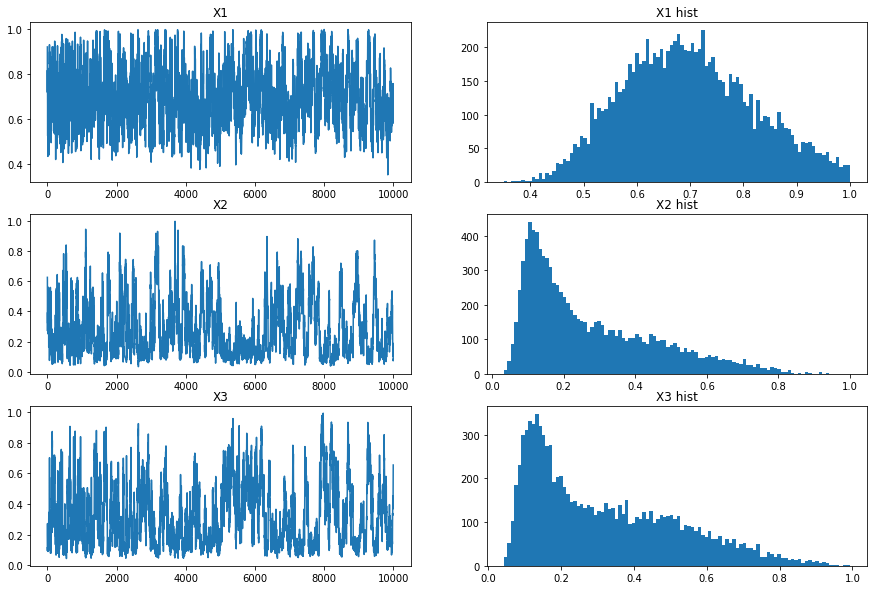

In [85]:
fig, a = plt.subplots(3,2, figsize=(15,10))
a[0,0].plot(vec_simu[:20000,0])
a[0,0].set_title('X1')
a[1,0].plot(vec_simu[:20000,1])
a[1,0].set_title('X2')
a[2,0].plot(vec_simu[:20000,2])
a[2,0].set_title('X3')
a[0,1].hist(vec_simu[:20000,0], bins=100)
a[0,1].set_title('X1 hist')
a[1,1].hist(vec_simu[:20000,1], bins=100)
a[1,1].set_title('X2 hist')
a[2,1].hist(vec_simu[:20000,2], bins=100)
a[2,1].set_title('X3 hist')

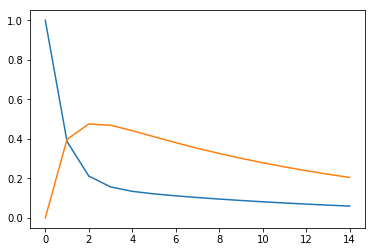

Estimation du vecteur x = [0.69696305 0.27632503 0.32026459]
Estimation empirique du maximum a posteriori de la quantité de matière dans le compartiment 2 = 0.475181535956602


In [86]:
estim = np.mean(vec_simu[0:20000,:], axis=0)
simu_ = simulateur(estim, q0, 15)
plt.plot(simu_)
plt.show()
print('Estimation du vecteur x =', estim)
print('Estimation empirique du maximum a posteriori de la quantité de matière dans le compartiment 2 =',np.max(simu_[:,1]))

**Conclusion**, les 2 derniers paramètres du vecteur sont indiscernables (c.f vraissemblance symétrique à x1 fixé) Cela explique que l'estimation des 2 paramètres soit la même dans les différentes chaînes proposées.